# Benchmarking MIMO Convolution

This is notebook aims at validating a batched implementation of the MIMO convolution. It validated against a basic implementation of the equation below.

In addition, the batched implementation is benchmarked against the loop-based implementation on GPU to demonstrate performance speed-ups

$$\begin{align*}
\mathbf{Y}[i][t] = \sum_{j=1}^{N_t}\sum_{k=0}^{l-1}\mathbf{H}[i][j][k] \cdot \mathbf{X}[j][t-k]
\end{align*}
$$

In [1]:
import torch
import numpy as np

from torch.nn.functional import conv1d

In [2]:
def mimo_conv_loop(input_signal, channel_tensor, d_type, batch_size, Nr, Nt, T):
    """
    Perform a MIMO (Multiple Input Multiple Output) convolution on the given input signal using the specified channel tensor.

    This function applies a convolutional operation across multiple antenna pairs over a multipath channel model. 
    The input signal matrix is convolved with the channel tensor to compute the received signal matrix.

    Args:
        input_signal (torch.Tensor): An input signal matrix of shape (Nt, T) where:
            - Nt: Number of transmit antennas
            - T: Length of the input signal for each antenna
        
        channel_tensor (torch.Tensor): A 4D tensor representing the channel model of shape (batch_size, Nr, Nt, l) where:
            - batch_size: Number of samples in the batch
            - Nr: Number of receive antennas
            - Nt: Number of transmit antennas
            - l: Number of paths in the multipath channel
        
        d_type (torch.dtype): Data type for the computation of the output tensor.
        
        batch_size (int): Number of samples in the batch.
        
        Nr (int): Number of receive antennas.
        
        Nt (int): Number of transmit antennas.
        
        T (int): Length of the received signal for each antenna.

    Returns:
        torch.Tensor: An output signal matrix of shape (batch_size, Nr, T) containing the convolved received signals.
    """
    # Pre-allocate the output signal Y of shape [batch_size, Nr, T]
    Y = torch.zeros(batch_size, Nr, T, dtype=d_type, device=input_signal.device)

    for b in range(batch_size):
        for i in range(Nr):
            for j in range(Nt):
                x_j = input_signal[j].view(1, 1, -1)  # Reshape to [batch size, channels, length]
                h_ij = channel_tensor[b, i, j].view(1, 1, -1)  # Reshape to [output channels, input channels, kernel size]

                # Convolution without padding
                y_ij = conv1d(x_j, h_ij, padding='same')

                # Summing up contributions
                Y[b,i,:] += y_ij.squeeze()
    
    return Y

In [3]:
def mimo_conv_batched(input_signal, channel_tensor, batch_size, Nr, Nt, l, T):
    """
    Perform a batched MIMO (Multiple Input Multiple Output) convolution on the input signal using the provided channel tensor.

    This function efficiently computes the convolution across a batch of samples using a broadcast operation, 
    applying the convolutional operation over multiple receive antennas simultaneously.

    Args:
        input_signal (torch.Tensor): A 3D input signal tensor of shape (1, Nt, T) where:
            - Nt: Number of transmit antennas
            - T: Length of the input signal for each antenna

        channel_tensor (torch.Tensor): A 4D tensor representing the channel model of shape (batch_size, Nr, Nt, l) where:
            - batch_size: Number of samples in the batch
            - Nr: Number of receive antennas
            - Nt: Number of transmit antennas
            - l: Number of paths in the multipath channel
        
        Nr (int): Number of receive antennas.
        
        Nt (int): Number of transmit antennas.
        
        l (int): Number of paths in the multipath channel.
        
        T (int): Length of the received signal for each antenna.

    Returns:
        torch.Tensor: An output signal matrix of shape (batch_size, Nr, T) containing the convolved received signals.
    """
    
    channel_tensor = channel_tensor.view(batch_size * Nr, Nt, l)  # Reshape H for conv1d: [(batch_size * Nr), Nt, l]
    Y = conv1d(input_signal, channel_tensor, padding='same')
    Y = Y.view(batch_size, Nr, T)

    return Y

In [4]:
# Simulation Parameters
Nr = 4  # Number of receive antennas
Nt = 4  # Number of transmit antennas
l = 23  # Kernel size (number of paths)
T = 128  # Length of the input signal

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Validating equivalence of both approaches

### float32

In [15]:
X_32 = torch.randn(1, Nt, T, dtype=torch.float32).to(device)
H_32 = torch.randn(16, Nr, Nt, l, dtype=torch.float32).flip(dims=[-1]).to(device)

In [16]:
X_32_loop = X_32.squeeze()
Y_loop_32 = mimo_conv_loop(X_32_loop, H_32, torch.float32, 16, Nr, Nt, T)

In [17]:
Y_batched_32 = mimo_conv_batched(X_32, H_32, 16, Nr, Nt, l, T)

In [9]:
tolerances = [10 ** (-i) for i in range(1, 65)]
tol = 0
for i, tolerance in enumerate(tolerances):
    flag = torch.allclose(Y_loop_32, Y_batched_32, atol=tolerance, rtol=0)
    if flag==False:
        tol = tolerances[i-1]
        break
tol

0.1

### float64

In [12]:
X_64 = torch.randn(1, Nt, T, dtype=torch.float64).to(device)
H_64 = torch.randn(16, Nr, Nt, l, dtype=torch.float64).flip(dims=[-1]).to(device)

In [13]:
X_64_loop = X_64.squeeze()
Y_loop_64 = mimo_conv_loop(X_64_loop, H_64, torch.float64, 16, Nr, Nt, T)

In [14]:
Y_batched_64 = mimo_conv_batched(X_64, H_64, 16, Nr, Nt, l, T)

In [15]:
tolerances = [10 ** (-i) for i in range(1, 65)]
tol = 0
for i, tolerance in enumerate(tolerances):
    flag = torch.allclose(Y_loop_64, Y_batched_64, atol=tolerance, rtol=0)
    if flag==False:
        tol = tolerances[i-1]
        break
tol

1e-13

since the discrepancy is too severe using float32 tensors, we will stick to float64 tensors

## GPU Benchmarking

In [14]:
# find optimal backend for performing convolutions 
torch.backends.cudnn.benchmark = True 

In [15]:
# INIT LOGGERS
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

In [16]:
repetitions = 100
batch_sizes = [2**i for i in range(11)]

### Benchmarking Loop-Based Implementation

In [17]:
timings_loop = np.zeros((repetitions, len(batch_sizes)))
timings_loop.shape

(100, 11)

In [18]:
X = torch.randn(1, Nt, T, dtype=torch.float64).to(device)
X_loop = X.squeeze()
print(X.shape, X_loop.shape) 

torch.Size([1, 4, 128]) torch.Size([4, 128])


In [19]:
#GPU warmup
warmup_iterations = 10
for _ in range(warmup_iterations):
    _ = mimo_conv_loop(X_loop, H_64, torch.float64, 16, Nr, Nt, T)

In [20]:
#Measure Performance
with torch.no_grad():
    for i, b in enumerate(batch_sizes):
        print(b)
        H = torch.randn(b, Nr, Nt, l, dtype=torch.float64).flip(dims=[-1]).to(device)
        for rep in range(repetitions):
            starter.record()
            _ = mimo_conv_loop(X_loop, H, torch.float64, b, Nr, Nt, T)
            ender.record()
            # WAIT FOR GPU SYNC
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings_loop[rep, i] = curr_time

1
2
4
8
16
32
64
128
256
512
1024


In [21]:
means_loop = timings_loop.mean(axis=0)
stds_loop = timings_loop.std(axis=0)
print(means_loop.shape, stds_loop.shape)

(11,) (11,)


### Benchmarking batched Implementation

In [23]:
timings_batched = np.zeros((repetitions, len(batch_sizes)))

In [24]:
#GPU warmup
for _ in range(warmup_iterations):
    _ = mimo_conv_batched(X, H_64, 16, Nr, Nt, l, T)

In [25]:
#Measure Performance
with torch.no_grad():
    for i, b in enumerate(batch_sizes):
        H = torch.randn(b, Nr, Nt, l, dtype=torch.float64).flip(dims=[-1]).to(device)
        for rep in range(repetitions):
            starter.record()
            _ = mimo_conv_batched(X, H, b, Nr, Nt, l, T)
            ender.record()
            # WAIT FOR GPU SYNC
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings_batched[rep, i] = curr_time

In [26]:
means_batched = timings_batched.mean(axis=0)
stds_batched = timings_batched.std(axis=0)
print(means_batched.shape, stds_batched.shape)

(11,) (11,)


## Plotting Results

In [27]:
import matplotlib.pyplot as plt

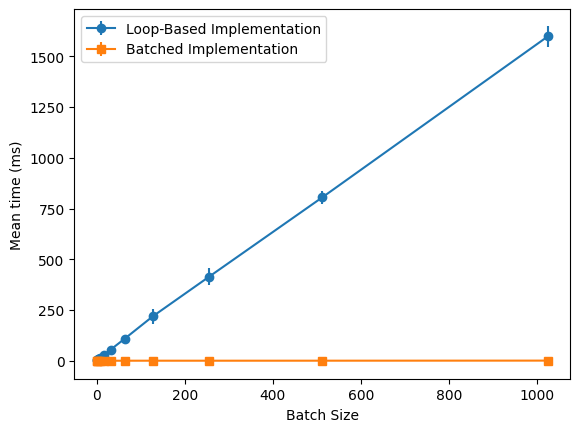

In [34]:
plt.figure()
plt.errorbar(batch_sizes, means_loop, yerr=stds_loop, label="Loop-Based Implementation", fmt='-o')
plt.errorbar(batch_sizes, means_batched, yerr=stds_batched, label="Batched Implementation", fmt='-s')
plt.legend()
plt.xlabel("Batch Size")
plt.ylabel("Mean time (ms)")
plt.show()

Batched operation is significantly faster and with less measurment standard deviation.
This is due to:
- batched/parallel operation (optimized on GPU)
- less context switching
- less function calls, synchronization overhead, kernel launches,...

## Dealing with complex data

$$\begin{align*}
\text{Re}(y) &= \text{Re}(x) * \text{Re}(k) - \text{Im}(x) * \text{Im}(k) \\
\text{Im}(y) &= \text{Re}(x) * \text{Im}(k) + \text{Im}(x) * \text{Re}(k)
\end{align*}$$


### Validating pytorch's output

In [39]:
X_C64 = torch.randn(1, Nt, T, dtype=torch.complex128).to(device)
H_C64 = torch.randn(2, Nr, Nt, l, dtype=torch.complex128).flip(dims=[-1]).to(device)

In [33]:
# Split into real and imaginary parts
X_real = X_C64.real
X_imag = X_C64.imag

H_real = H_C64.real
H_imag = H_C64.imag

In [34]:
# Compute convolutions for real and imaginary parts
Y_real_real = mimo_conv_batched(X_real, H_real, 1, Nr, Nt, l, T)
Y_real_imag = mimo_conv_batched(X_real, H_imag, 1, Nr, Nt, l, T)
Y_imag_real = mimo_conv_batched(X_imag, H_real, 1, Nr, Nt, l, T)
Y_imag_imag = mimo_conv_batched(X_imag, H_imag, 1, Nr, Nt, l, T)

In [35]:
# Combine to form complex convolution output
Y_real = Y_real_real - Y_imag_imag
Y_imag = Y_real_imag + Y_imag_real

In [36]:
# Create final complex tensor
Y_C64 = torch.complex(Y_real, Y_imag)

In [37]:
Y_batched = mimo_conv_batched(X_C64, H_C64, 1, Nr, Nt, l, T)

In [38]:
tolerances = [10 ** (-i) for i in range(1, 65)]
tol = 0
for i, tolerance in enumerate(tolerances):
    flag = torch.allclose(Y_C64, Y_batched, atol=tolerance, rtol=0)
    if flag==False:
        tol = tolerances[i-1]
        break
tol

1e-13

## Preparing Tensor for Convolution

In [11]:
import yaml

In [12]:
# Load the YAML file
with open("normalized_delays.yaml", "r") as yaml_file:
    data = yaml.safe_load(yaml_file)

# Extract the list of normalized delays
normalized_delays = data["normalized_delays"]
normalized_delays

[0.0,
 0.3819,
 0.4025,
 0.5868,
 0.461,
 0.5375,
 0.6708,
 0.575,
 0.7618,
 1.5375,
 1.8978,
 2.2242,
 2.1718,
 2.4942,
 2.5119,
 3.0582,
 4.081,
 3.7648,
 4.5695,
 4.7966,
 5.0066,
 5.3043,
 9.6586]

In [13]:
delay_spread = 300e-9
fs = 30.72e6
Ts = 1/fs  # Example sampling time (replace with actual)
delays_sec = np.array(normalized_delays) * delay_spread
sample_indices = np.round(delays_sec / Ts).astype(int)
sample_indices
delays_sec

array([0.00000e+00, 1.14570e-07, 1.20750e-07, 1.76040e-07, 1.38300e-07,
       1.61250e-07, 2.01240e-07, 1.72500e-07, 2.28540e-07, 4.61250e-07,
       5.69340e-07, 6.67260e-07, 6.51540e-07, 7.48260e-07, 7.53570e-07,
       9.17460e-07, 1.22430e-06, 1.12944e-06, 1.37085e-06, 1.43898e-06,
       1.50198e-06, 1.59129e-06, 2.89758e-06])

In [14]:
sample_indices

array([ 0,  4,  4,  5,  4,  5,  6,  5,  7, 14, 17, 20, 20, 23, 23, 28, 38,
       35, 42, 44, 46, 49, 89])

In [40]:
sample_indices = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 14, 17, 19, 20, 22, 23, 28, 35, 38, 42, 44, 46, 49, 89], device=device)

In [67]:
# Find the required length for the final tensor
channel_vector_length = max(sample_indices).item() + 1

# Initialize the destination tensor with zeros
destination_tensor = torch.zeros((2, Nr, Nt, channel_vector_length), dtype=torch.complex64, device=device)

# Create index tensors
Nr_indices = torch.arange(Nr, device=device).view(1, -1, 1, 1)  #
Nt_indices = torch.arange(Nt, device=device).view(1, 1, -1, 1)  
sample_indicess = sample_indices.view(1, 1, 1, -1)  # Shape (1, 1, l)
batch_indices = torch.arange(2, device=device).view(-1,1,1,1)

# Use broadcasting to copy the original tensor's paths into the destination tensor
destination_tensor[batch_indices, Nr_indices, Nt_indices, sample_indicess] = H_C64

print(H_C64.shape, destination_tensor.shape)

torch.Size([2, 4, 4, 23]) torch.Size([2, 4, 4, 90])
